This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os

from src_python.cell_tree import CellTree

In [3]:
def create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix):
    n_cells = mutation_matrix.shape[1]
    n_loci = len(selected) + len(not_selected_genotypes)
    genotype_matrix = np.full((n_loci, n_cells),"", dtype="str")
    not_selected = [i for i in range(n_loci) if i not in selected]
    # those not selected have a gt independent of the tree learning
    for n, locus in enumerate(not_selected):
        genotype_matrix[locus] = [not_selected_genotypes[n] for _ in range(n_cells)]
    # these are the genes selected for the tree learning
    for n, locus in enumerate(selected):
        genotype_matrix[locus] = np.where(mutation_matrix[n] == 0, gt1[n], np.where(mutation_matrix[n] == 1, gt2[n], mutation_matrix[n]))
    return genotype_matrix

def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_cells = len(parent_vector)
    n_leaves = int((n_cells+1)/2)
    n_mutations = len(mutation_indices)

    # Initialize mutation matrix with zeros
    mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)

    # Mark cells with mutations
    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves].T

In [4]:
path = "../data/simulated_data"

n_cells = [100, 100, 50]
n_mut = [50, 100, 100]
n_tests = 100
clones = [5, 10, 20, ""]
stratified = ""  # "_stratified"

In [5]:
genotype_differences = {}
genotype_differences["SCITE-RNA"] = {}

for n_c, n_m in zip(n_cells, n_mut):
    genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
    for clone in clones:
        differences = []
        for t in range(n_tests):
            base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
            genotype_pred_path = os.path.join(base_path, "sciterna_genotype", f"sciterna_genotype_{t}.txt")
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
            ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
            alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
    
            if not os.path.exists(genotype_pred_path):
                os.makedirs(os.path.join(base_path, "sciterna_genotype"), exist_ok=True)
                not_selected_path = os.path.join(base_path, "sciterna_not_selected_genotypes", f"sciterna_not_selected_genotypes_{t}.txt")
                selected_path = os.path.join(base_path, "sciterna_selected_loci", f"sciterna_selected_loci_{t}.txt")
                genotypes_path = os.path.join(base_path, "sciterna_inferred_mut_types", f"sciterna_inferred_mut_types_{t}.txt")
                mut_loc_path = os.path.join(base_path, "sciterna_mut_loc", f"sciterna_mut_loc_{t}.txt")
                parent_path = os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{t}.txt")
                
                if os.path.getsize(not_selected_path) > 0:
                    not_selected_genotypes = np.loadtxt(not_selected_path, dtype=str)
                else:
                    not_selected_genotypes = np.array([])
    
                selected = np.loadtxt(selected_path, dtype=int)
                genotypes = np.loadtxt(genotypes_path, dtype=str)
                mutation_loc = np.loadtxt(mut_loc_path, dtype=int)
                sciterna_parent_vec = np.loadtxt(parent_path, dtype=int)
                gt1 = genotypes[0]
                gt2 = genotypes[1]
                
                ct = CellTree(n_cells)
                ct.use_parent_vec(sciterna_parent_vec)
                ct.mut_loc = mutation_loc
                
                mutation_matrix = create_mutation_matrix(ct.parent_vec, ct.mut_loc, ct)
                genotype = create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix)
                np.savetxt(genotype_pred_path, genotype, fmt='%s')
            
            genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
            gt = np.loadtxt(genotype_path, dtype=str)
            alt = np.loadtxt(alt_path)
            ref = np.loadtxt(ref_path)
            
            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype_predicted = vectorized_map(genotype_pred)
            genotype = vectorized_map(gt)
                        
            # difference = np.sum(genotype_predicted != genotype)
            difference = np.sum(np.abs(genotype_predicted - genotype))
            differences.append(difference/(n_c * n_m))

        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences        
        print(np.mean(differences), " mean abs difference of vafs predicted")

0.013770000000000003  mean abs difference of vafs predicted
0.011836  mean abs difference of vafs predicted
0.009873999999999999  mean abs difference of vafs predicted
0.013610000000000002  mean abs difference of vafs predicted
0.009941499999999999  mean abs difference of vafs predicted
0.008350499999999999  mean abs difference of vafs predicted
0.007169  mean abs difference of vafs predicted
0.008536499999999999  mean abs difference of vafs predicted
0.012688999999999999  mean abs difference of vafs predicted
0.010073999999999998  mean abs difference of vafs predicted
0.008082  mean abs difference of vafs predicted
0.01064  mean abs difference of vafs predicted


In [6]:
genotype_differences["SClineager"] = {}

for n_c, n_m in zip(n_cells, n_mut):
    genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
    for clone in clones:
        differences = []
        for t in range(n_tests):
            base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
            vaf_pred_path = os.path.join(base_path, "sclineager_vaf", f"sclineager_vaf_{t}.txt")
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
            ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
            alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
    
            vaf_pred = np.loadtxt(vaf_pred_path, dtype=float)
            gt = np.loadtxt(genotype_path, dtype=str)
            alt = np.loadtxt(alt_path)
            ref = np.loadtxt(ref_path)
            
            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype = vectorized_map(gt)
            
            vaf_pred = np.round(vaf_pred * 2) / 2
            difference = np.sum(np.abs(vaf_pred - genotype))
            differences.append(difference/(n_c * n_m))

                
        genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences        
        print(np.mean(differences), " mean abs difference of vafs predicted")

0.024363000000000003  mean abs difference of vafs predicted
0.028868000000000005  mean abs difference of vafs predicted
0.031848  mean abs difference of vafs predicted
0.023807999999999992  mean abs difference of vafs predicted
0.022965999999999993  mean abs difference of vafs predicted
0.0272185  mean abs difference of vafs predicted
0.029493000000000005  mean abs difference of vafs predicted
0.023035500000000004  mean abs difference of vafs predicted
0.027385000000000003  mean abs difference of vafs predicted
0.033097999999999995  mean abs difference of vafs predicted
0.03720999999999999  mean abs difference of vafs predicted
0.029847999999999996  mean abs difference of vafs predicted


In [7]:
path = "D:\PhD\simulation_data_scite_rna"
genotype_differences["DENDRO"] = {}

for n_c, n_m in zip(n_cells, n_mut):
    genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
    for clone in clones:
        differences = []
        for t in range(n_tests):
            base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
            clones_pred_path = os.path.join(base_path, "dendro_clones", f"dendro_clones_{t}.txt")
            clones_pred = np.loadtxt(clones_pred_path, dtype=float)
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
            ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
            alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
    
            gt = np.loadtxt(genotype_path, dtype=str)
            alt = np.loadtxt(alt_path)
            ref = np.loadtxt(ref_path)
            with np.errstate(invalid='ignore'):
                vaf_observed = alt/(alt+ref)
            
            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype = vectorized_map(gt)
            
            unique_classes = np.unique(clones_pred)
    
            # For each unique class, replace column values with the mean of the columns of that class
            for cls in unique_classes:
                class_indices = np.where(clones_pred == cls)[0]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)
                
                # in case the mean is nan replace it with the mean genotype over all cells
                row_nanmean = np.nanmean(vaf_observed, axis=1)
                if np.isnan(row_nanmean).any():
                    raise ValueError("Error: The array contains NaN values.")
                mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                if np.isnan(mean_values).any():
                    raise ValueError("Error: The array contains NaN values.")
                
                vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))
                    
                
            vaf_observed_rounded = np.round(vaf_observed * 2) / 2
            if np.isnan(vaf_observed_rounded).any():
                print("Error: The array contains NaN values.")
            
            difference = np.sum(np.abs(vaf_observed_rounded - genotype))
            differences.append(difference/(n_c * n_m))
                
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences           
        print(np.mean(differences), " mean abs difference of vafs predicted")

0.018104999999999996  mean abs difference of vafs predicted
0.033734999999999994  mean abs difference of vafs predicted
0.048026  mean abs difference of vafs predicted
0.050793  mean abs difference of vafs predicted
0.010718  mean abs difference of vafs predicted
0.024354000000000004  mean abs difference of vafs predicted
0.040627500000000004  mean abs difference of vafs predicted
0.06061299999999999  mean abs difference of vafs predicted
0.018373999999999998  mean abs difference of vafs predicted
0.039557  mean abs difference of vafs predicted
0.05921500000000001  mean abs difference of vafs predicted
0.070282  mean abs difference of vafs predicted


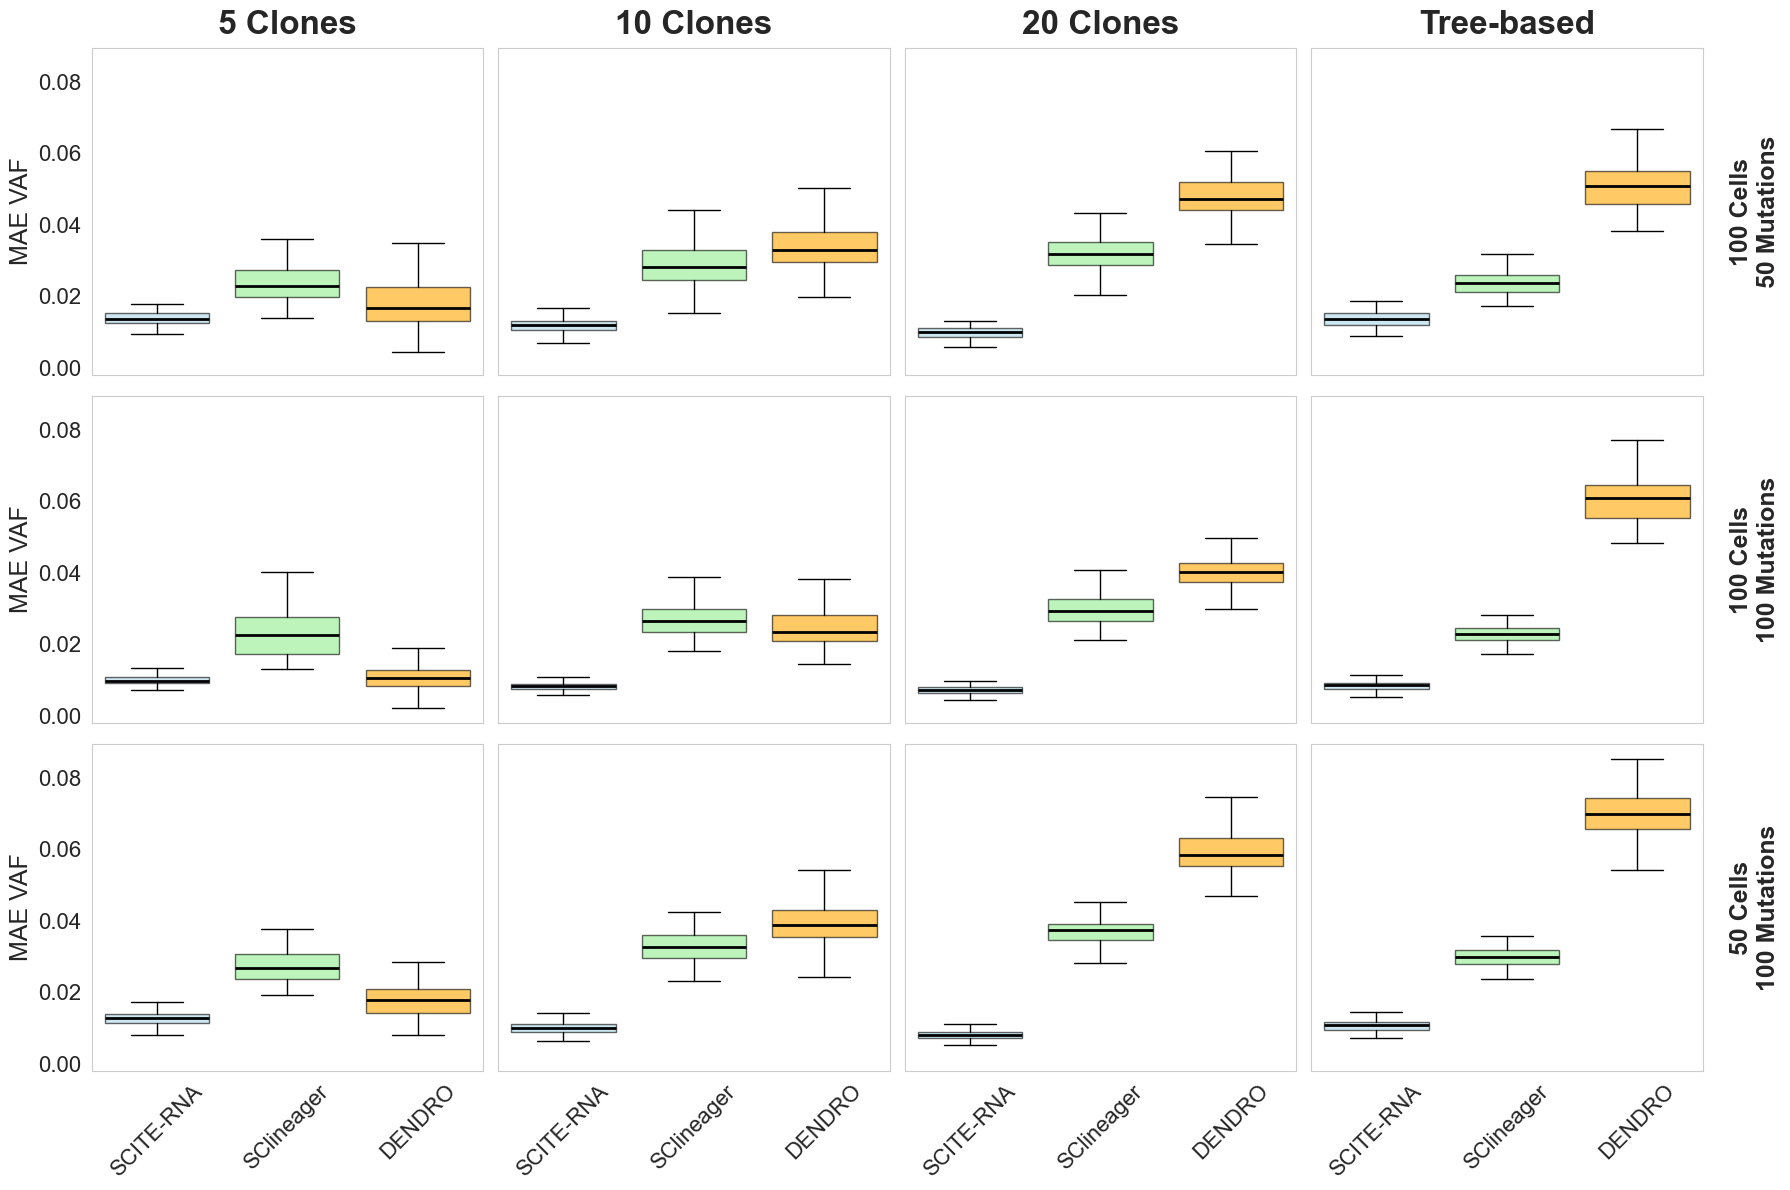

In [8]:
models = ["SCITE-RNA", "SClineager", "DENDRO"]

clones =[5, 10, 20, ""]

fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=True)

colors = ["lightblue", "lightgreen", "orange"]
alpha_value = 0.6

title_size = 24
label_size = 18
tick_size = 16
box_width = 2.0
boxplot_widths = 0.8

for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
    for col_idx, clone in enumerate(clones):
        all_samples = []
        for model in models:
            all_samples.append(genotype_differences[model][f"{n_c}_{n_m}"][clone])
        
        ax = axes[row_idx, col_idx]
        box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
        
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha_value)
        
        for line in box['medians']:
            line.set_linewidth(box_width)
            line.set_color("black")
        
        if row_idx == 0:
            if clone == "":
                ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
            else:
                ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

        if row_idx == 2:
            ax.set_xticklabels(models, fontsize=tick_size)
        else:
            ax.set_xticks([])  # Remove x-ticks for the higher rows

        if col_idx == 0:
            ax.set_ylabel('MAE VAF', fontsize=label_size)
        if col_idx == 3:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size, rotation=90, labelpad=20, fontproperties=FontProperties(weight='bold'))

        ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid(False)

plt.tight_layout()
plt.savefig("../data/results/figures/clones.png")
plt.show()

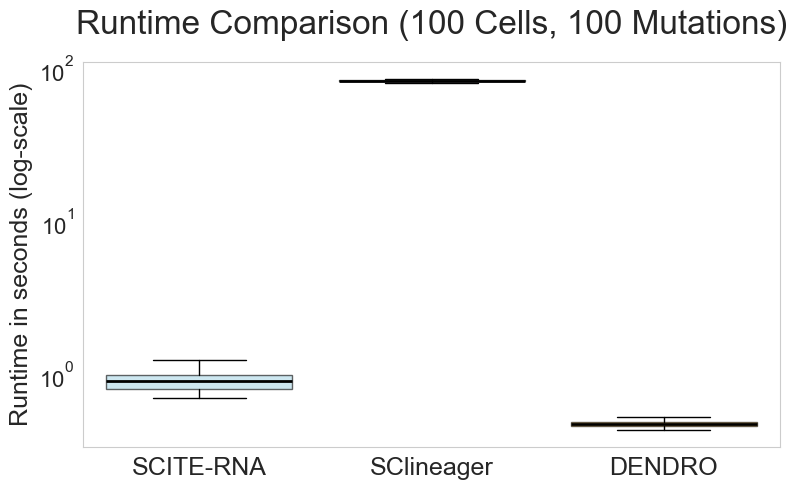

In [9]:
base_path = os.path.join(path, f"{100}c{100}m{10}{stratified}")

runtime_sclineager = np.loadtxt(os.path.join(base_path, "execution_times_sclineager.txt"))
runtime_dendro = np.loadtxt(os.path.join(base_path, "execution_times_dendro.txt"))
runtime_sciterna = np.loadtxt(os.path.join(base_path, "execution_times_sciterna.txt"))

data = [runtime_sciterna, runtime_sclineager, runtime_dendro]

plt.figure(figsize=(8, 5))
box = plt.boxplot(data, patch_artist=True, widths=boxplot_widths, showfliers=False)

colors = ["lightblue", "lightgreen", "orange"]
alpha_value = 0.6
box_width = 2.0

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(alpha_value)

for line in box['medians']:
    line.set_linewidth(box_width)
    line.set_color("black")

plt.title("Runtime Comparison (100 Cells, 100 Mutations)", fontsize=24, pad=20)
plt.ylabel('Runtime in seconds (log-scale)', fontsize=18)
plt.yscale('log')
plt.xticks(ticks=[1, 2, 3], labels=models, fontsize=18)  
plt.tick_params(axis='y', labelsize=16)
plt.grid(False)

plt.tight_layout()
plt.savefig("../data/results/figures/runtimes.png")
plt.show()